# Scripts for Scaling of IR trends with Calibrated HPLC Datapoints.

### Import Necessary Packages

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.optimize import minimize

### Small Functions used in Main Funtion

In [2]:
import numpy as np
from scipy.optimize import minimize

def align_ir_to_hplc(ir_time, ir_data, hplc_time):
    """
    Align IR data to HPLC time points by linear interpolation.
    
    Parameters:
        ir_time (array-like): Timestamps corresponding to IR data.
        ir_data (array-like): IR intensity values.
        hplc_time (array-like): Target time points from HPLC.

    Returns:
        np.ndarray: Interpolated IR data at HPLC time points.
    """
    return np.interp(hplc_time, ir_time, ir_data)


def scaling_function(x, a, b):
    """
    Apply linear scaling transformation to input data.
    
    Parameters:
        x (array-like): Input data.
        a (float): Scaling factor.
        b (float): Offset.

    Returns:
        np.ndarray: Scaled data.
    """
    return a * x + b


def scale_ir_to_hplc_with_mass_balance(hplc_sm, hplc_product, aligned_ir_sm, aligned_ir_product):
    """
    Fit and scale IR traces (starting material and product) to match HPLC data using linear
    transformations. This also enforces mass balance between the IR traces and the HPLC measurements.
    
    The objective function minimizes both:
      - the squared error between HPLC and scaled IR traces
      - the deviation from a constant total mass across all time points

    Parameters:
        hplc_sm (np.ndarray): HPLC data for starting material.
        hplc_product (np.ndarray): HPLC data for product.
        aligned_ir_sm (np.ndarray): IR data for starting material aligned to HPLC time.
        aligned_ir_product (np.ndarray): IR data for product aligned to HPLC time.

    Returns:
        tuple:
            scaled_sm (np.ndarray): Scaled IR trace for starting material.
            scaled_product (np.ndarray): Scaled IR trace for product.
            (a_sm, b_sm, a_product, b_product) (tuple): Fitted scaling parameters.
    """
    
    # Estimate the average total mass from HPLC as a reference for balancing
    hplc_total_mass = (hplc_sm + hplc_product).mean()

    def mass_balance_cost(params):
        """
        Cost function combining:
        - fitting error to match HPLC
        - penalty for breaking mass conservation
        
        Parameters:
            params (list): [a_sm, b_sm, a_product, b_product]
        
        Returns:
            float: Total error.
        """
        a_sm, b_sm, a_product, b_product = params

        # Apply linear scaling to the IR data
        scaled_sm = scaling_function(aligned_ir_sm, a_sm, b_sm)
        scaled_product = scaling_function(aligned_ir_product, a_product, b_product)

        # Sum the scaled IR data for total mass
        scaled_total_mass = scaled_sm + scaled_product

        # Compute squared error between IR and HPLC data
        fit_error = np.sum((hplc_sm - scaled_sm) ** 2 + (hplc_product - scaled_product) ** 2)

        # Compute squared deviation from total HPLC mass (mass balance constraint)
        mass_balance_error = np.sum((scaled_total_mass - hplc_total_mass) ** 2)

        return fit_error + mass_balance_error

    # Initial guess for the optimization [scale, offset] for each IR trace
    initial_guess = [1.0, 0.0, 1.0, 0.0]

    # Perform constrained optimization using the L-BFGS-B algorithm
    result = minimize(mass_balance_cost, initial_guess, method="L-BFGS-B")

    # Extract optimized parameters
    a_sm, b_sm, a_product, b_product = result.x

    # Apply the optimal scaling to the aligned IR data
    scaled_sm = scaling_function(aligned_ir_sm, a_sm, b_sm)
    scaled_product = scaling_function(aligned_ir_product, a_product, b_product)

    return scaled_sm, scaled_product, (a_sm, b_sm, a_product, b_product)


### Main Function for IR HPLC Scaling

In [3]:
def scale_and_save_to_excel_full_dataset(
    ir_file,
    hplc_file,
    additions_file,
    output_name="scaled_ir_hplc_output.xlsx",
    xlim_max=None,
    borders=False,
    labels=False,
    figsize=None,
    legend_fontscale=1,
    legend_outside=False,
    label_y_position=None,
    save_vtna_dataset=True,
    save_svg=True
):
    """
    Aligns and scales IR data to HPLC data across multiple regions defined in the additions file.
    Optionally exports the scaled data to an Excel file, and generates comparison plots.

    Parameters:
        ir_file (str): Path to CSV file with IR data (time, SM, product).
        hplc_file (str): Path to CSV file with HPLC data (time, SM, product).
        additions_file (str): Path to CSV file listing start times and initial concentrations.
        output_name (str): Filename for Excel output (if saving is enabled).
        xlim_max (float): Optional x-axis limit for plots.
        borders (bool): Whether to add vertical dashed lines between regions.
        labels (bool or list): Add region labels on plot. If list, uses provided strings.
        figsize (tuple): Custom figure size for plot.
        legend_fontscale (float): Multiplier for legend font size.
        legend_outside (bool): Place legend outside the plot area.
        label_y_position (float): Custom vertical position for region labels.
        save_vtna_dataset (bool): If True, saves the Excel file. If False, only plots are shown.
    """
    ir_df = pd.read_csv(ir_file)
    hplc_df = pd.read_csv(hplc_file)
    additions_df = pd.read_csv(additions_file)

    ir_time_col, ir_sm_col, ir_product_col = ir_df.columns[:3]
    hplc_time_col, hplc_sm_col, hplc_product_col = hplc_df.columns[:3]

    ir_time = ir_df[ir_time_col]
    ir_sm = ir_df[ir_sm_col]
    ir_product = ir_df[ir_product_col]
    hplc_time = hplc_df[hplc_time_col]
    hplc_sm = hplc_df[hplc_sm_col]
    hplc_product = hplc_df[hplc_product_col]

    writer = pd.ExcelWriter(output_name, engine='xlsxwriter') if save_vtna_dataset else None
    fig, ax = plt.subplots(figsize=figsize if figsize else (10, 6))
    colors = plt.colormaps.get_cmap("tab10")

    for i, row in additions_df.iterrows():
        region_start = row['start']
        init_B = row['Init B']
        init_phenol = row['Init phenol']

        region_end = additions_df.iloc[i + 1]['start'] if i < len(additions_df) - 1 else ir_time.max() + 1

        # Apply time masks for current region
        time_mask = (ir_time >= region_start) & (ir_time <= region_end)
        hplc_mask = (hplc_time >= region_start) & (hplc_time <= region_end)

        # Extract data for the region
        ir_time_region = ir_time[time_mask]
        hplc_time_region = hplc_time[hplc_mask]
        hplc_sm_region = hplc_sm[hplc_mask]
        hplc_product_region = hplc_product[hplc_mask]

        # Align and scale IR to HPLC
        aligned_ir_sm_region = align_ir_to_hplc(ir_time_region, ir_sm[time_mask], hplc_time_region)
        aligned_ir_product_region = align_ir_to_hplc(ir_time_region, ir_product[time_mask], hplc_time_region)

        scaled_ir_sm, scaled_ir_product, params = scale_ir_to_hplc_with_mass_balance(
            hplc_sm_region, hplc_product_region, aligned_ir_sm_region, aligned_ir_product_region
        )

        IR_sm_scaled_region = scaling_function(ir_sm[time_mask], params[0], params[1])
        IR_Prod_scaled_region = scaling_function(ir_product[time_mask], params[2], params[3])

        # Derived concentrations
        amine_conc = init_B - IR_Prod_scaled_region
        phenol_conc = init_phenol + IR_Prod_scaled_region

        # Create and save region DataFrame
        region_df = pd.DataFrame({
            'Time (min)': ir_time_region - ir_time_region.iloc[0],
            'ArOPh': IR_sm_scaled_region,
            'Product': IR_Prod_scaled_region,
            'Amine': amine_conc,
            'Phenol': phenol_conc
        })

        if save_vtna_dataset:
            region_df.to_excel(writer, sheet_name=f'Addition {i+1}', index=False)

        # Plotting
        color = colors(i % 10)
        ax.plot(ir_time_region, IR_sm_scaled_region, '--', label=f'Scaled IR period {i+1}', color=color, alpha=0.6)
        ax.plot(hplc_time_region, hplc_sm_region, 'o', label=f'HPLC period {i+1}', color=color)
        ax.plot(ir_time_region, IR_Prod_scaled_region, '--', color=color, alpha=0.6)
        ax.plot(hplc_time_region, hplc_product_region, 'o', color=color)

        if borders and i > 0:
            ax.axvline(region_start, linestyle=':', color='black', alpha=0.7)

        if labels and isinstance(labels, list) and i < len(labels):
            y_pos = label_y_position if label_y_position is not None else ax.get_ylim()[1] * 0.99
            x_start = region_start + (region_end - region_start) * 0.1
            if row.iloc[1] == additions_df.iloc[-1].iloc[1]:
                x_start = region_start + (ax.get_xlim()[1] - region_start) * 0.1
            ax.text(x_start, y_pos, labels[i], fontsize=10, verticalalignment='top')

    # Final plot formatting
    ax.set_xlabel('Time / minutes')
    ax.set_ylabel('Concentration / mM')
    ax.set_title('HPLC and Scaled IR Data Comparison')
    ax.set_xlim(0, xlim_max if xlim_max else ir_time_region.max() * 1.005)
    ax.set_ylim(0, None)

    base_fontsize = plt.rcParams.get('legend.fontsize', 10)
    if isinstance(base_fontsize, str):
        base_fontsize = 10

    legend_kwargs = {'prop': {'size': base_fontsize * legend_fontscale}}
    if legend_outside:
        legend_kwargs.update({
            'bbox_to_anchor': (1.05, 1),
            'loc': 'upper left',
            'borderaxespad': 0.
        })
        plt.subplots_adjust(right=0.75)

    ax.legend(**legend_kwargs)
    plt.tight_layout()
    if save_svg:
        plt.savefig(f"HPLC_IR_plot_{output_name.replace('.xlsx','')}_plots.svg", format='svg', dpi=300)
    plt.show()

    if save_vtna_dataset:
        writer.close()
        print(f"Excel file '{output_name}' has been saved.")

### Define Paths to Input Files 

In [4]:
path_IR_trends=os.getcwd()+'\\Roughly scaled IR data'
path_HPLC=os.getcwd()+'\\Calibrated HPLC data'
path_Additions=os.getcwd()+'\\Initial concentrations and start times for SAKE periods'

### Examples of Use

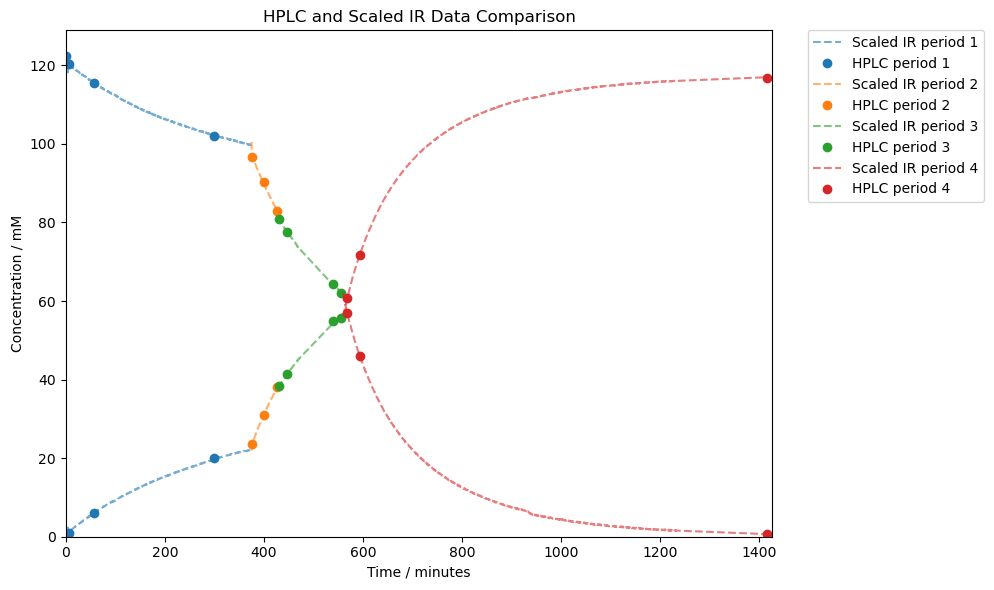

Excel file 'C1_E1 VTNA dataset.xlsx' has been saved.


In [5]:
# Example usage
ir_file = path_IR_trends + '\\C1_E1_trends_data.csv'
hplc_file = path_HPLC +'\\C1_E1 data HPLC.csv'
additions_file = path_Additions + '\\C1_E1 additions.csv'
output= 'C1_E1 VTNA dataset.xlsx'
scale_and_save_to_excel_full_dataset(ir_file, hplc_file, additions_file,output,legend_outside=True)

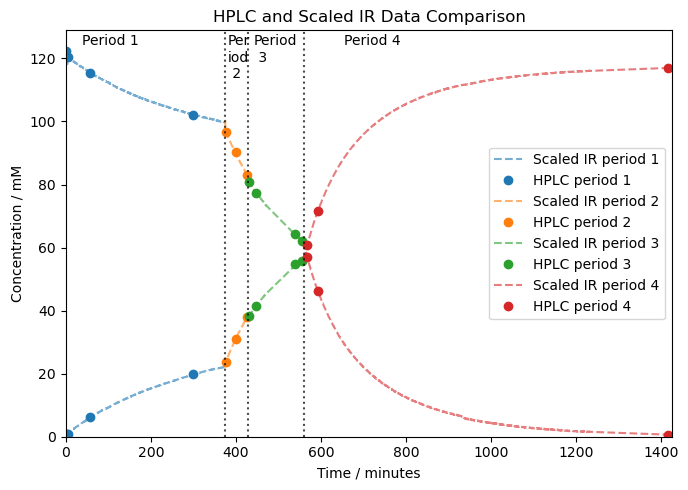

In [6]:
# Example usage
ir_file = path_IR_trends + '\\C1_E1_trends_data.csv'
hplc_file = path_HPLC +'\\C1_E1 data HPLC.csv'
additions_file = path_Additions + '\\C1_E1 additions.csv'
output= 'C1_E1 VTNA dataset.xlsx'
scale_and_save_to_excel_full_dataset(ir_file, hplc_file, additions_file,
                                     output,labels=['Period 1','Per\niod\n 2','Period\n 3','Period 4'],figsize=[7,5],
                                     borders=True,legend_fontscale=1,legend_outside=False,save_vtna_dataset=False)

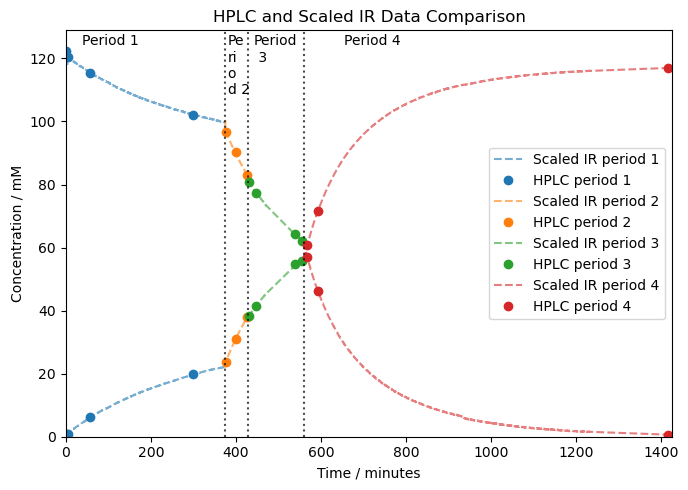

In [7]:
# Example usage
ir_file = path_IR_trends + '\\C1_E1_trends_data.csv'
hplc_file = path_HPLC +'\\C1_E1 data HPLC.csv'
additions_file = path_Additions + '\\C1_E1 additions.csv'
output= 'C1_E1 VTNA dataset.xlsx'
scale_and_save_to_excel_full_dataset(ir_file, hplc_file, additions_file,
                                     output,labels=['Period 1','Pe\nri\no\nd 2','Period\n 3','Period 4'],figsize=[7,5],
                                     borders=True,legend_fontscale=1,legend_outside=False,save_vtna_dataset=False)

### Loop to Generate Scaling Plots for all other SAKE Experiments

In [8]:
Experiments=[]
for file in os.listdir(path_HPLC): 
    Experiments.append(file[:-14].replace(' ',''))

In [9]:
Experiments

['C1_E1',
 'C1_E2',
 'C1_E3',
 'C1_E4a',
 'C1_E4b',
 'C1_E5',
 'C1_E6',
 'C1_E7',
 'C2_E1',
 'C2_E2',
 'C2_E3',
 'C2_E4',
 'C2_E5',
 'C2_E6',
 'C2_E7a',
 'C2_E7b',
 'C3_E1',
 'C3_E2',
 'C3_E3',
 'C3_E4',
 'C3_E5',
 'C4_E10',
 'C4_E11',
 'C4_E1a',
 'C4_E1b',
 'C4_E2',
 'C4_E3',
 'C4_E4',
 'C4_E5',
 'C4_E6',
 'C4_E7',
 'C4_E8',
 'C4_E9']

Generating HPLC IR Scaling plot for C1_E1:


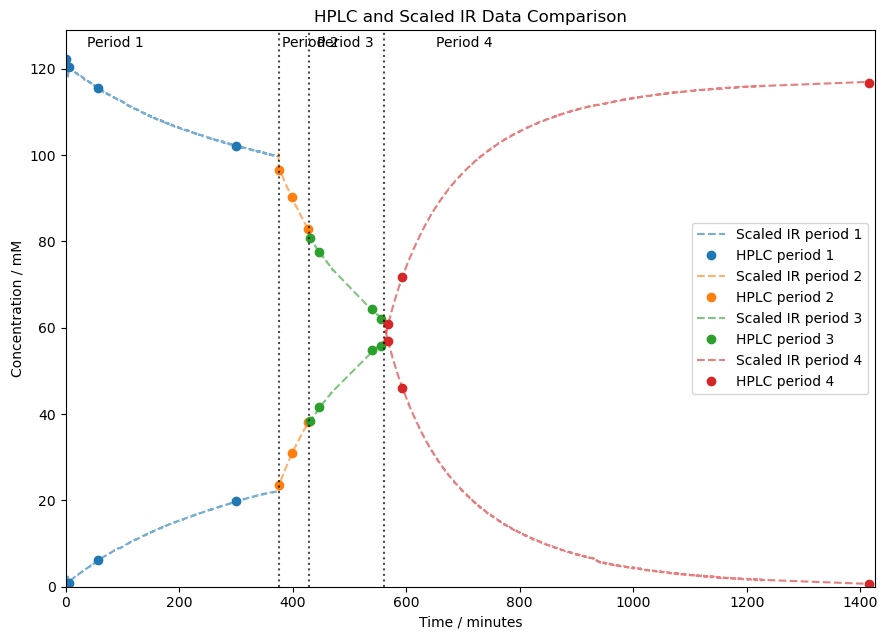

Generating HPLC IR Scaling plot for C1_E2:


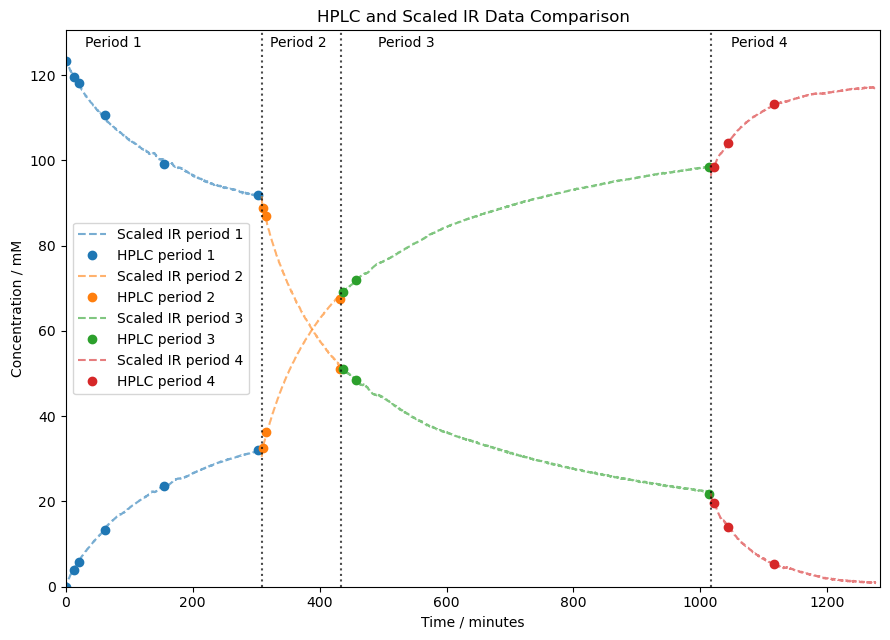

Generating HPLC IR Scaling plot for C1_E3:


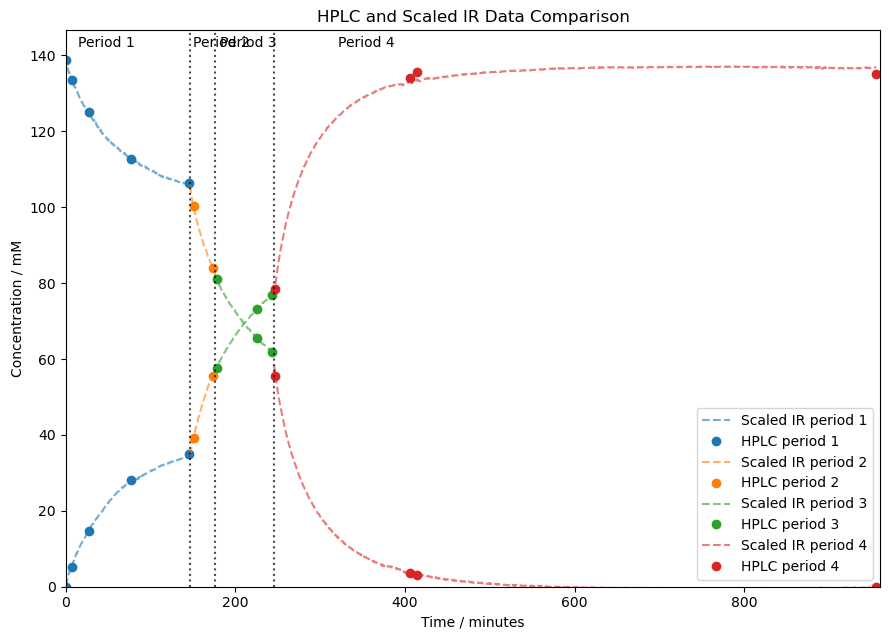

Generating HPLC IR Scaling plot for C1_E4a:


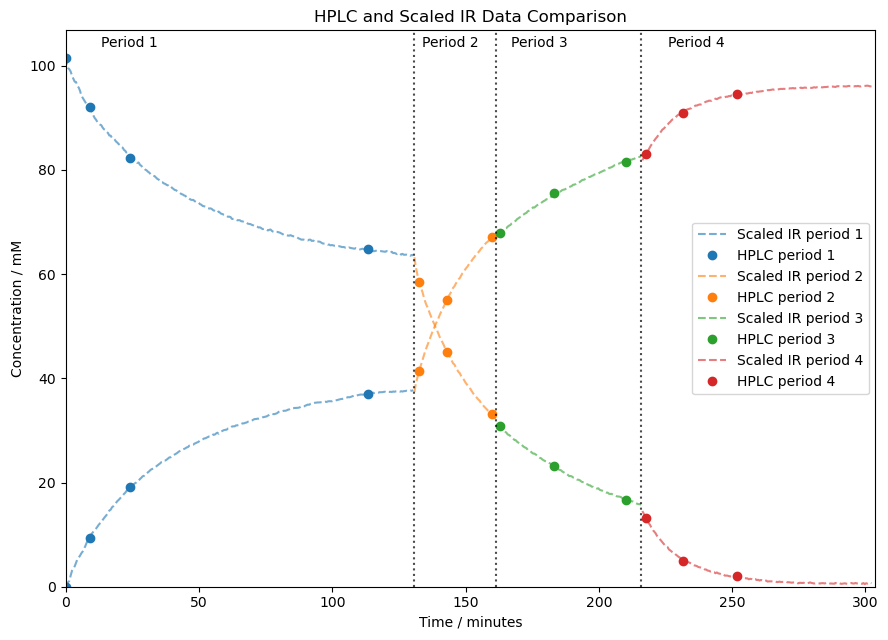

Generating HPLC IR Scaling plot for C1_E4b:


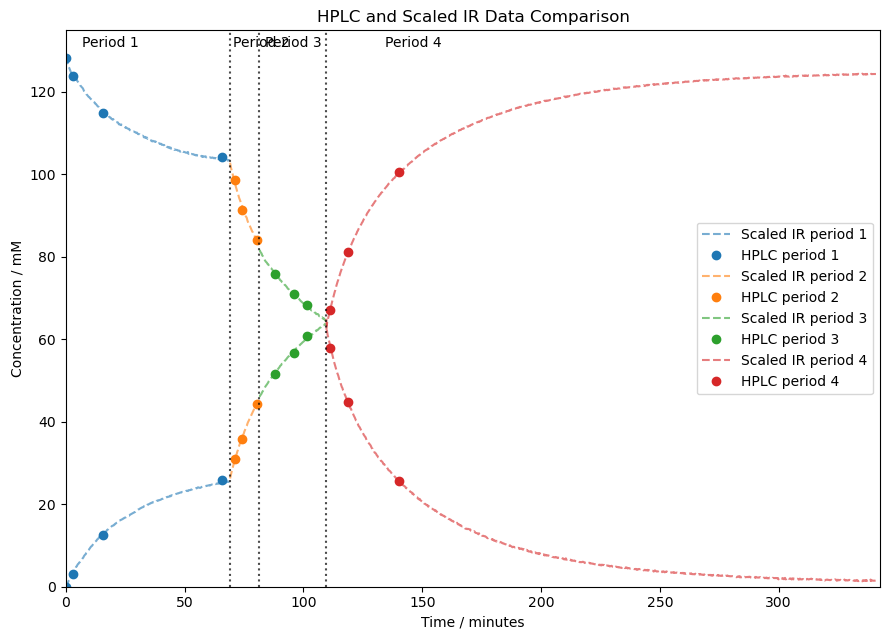

Generating HPLC IR Scaling plot for C1_E5:


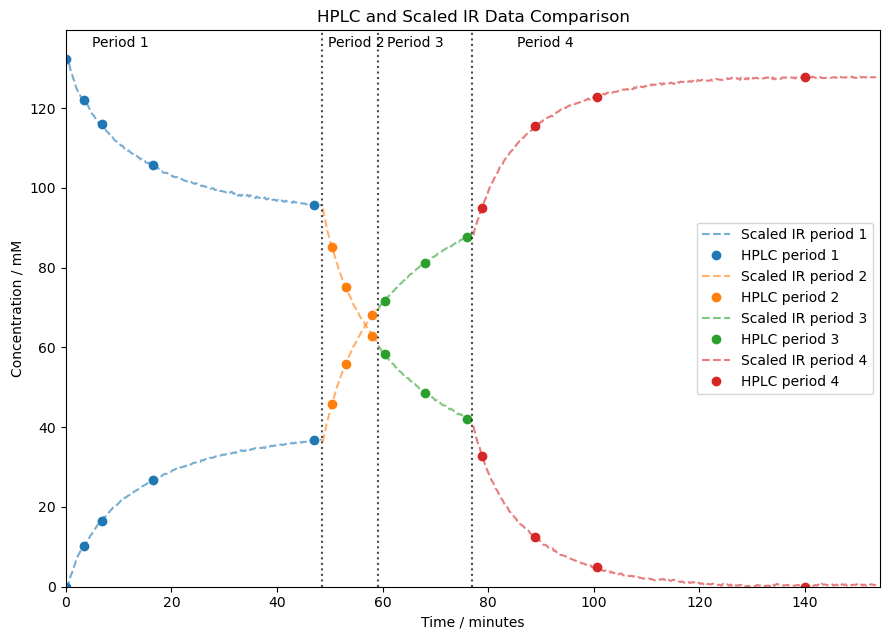

Generating HPLC IR Scaling plot for C1_E6:


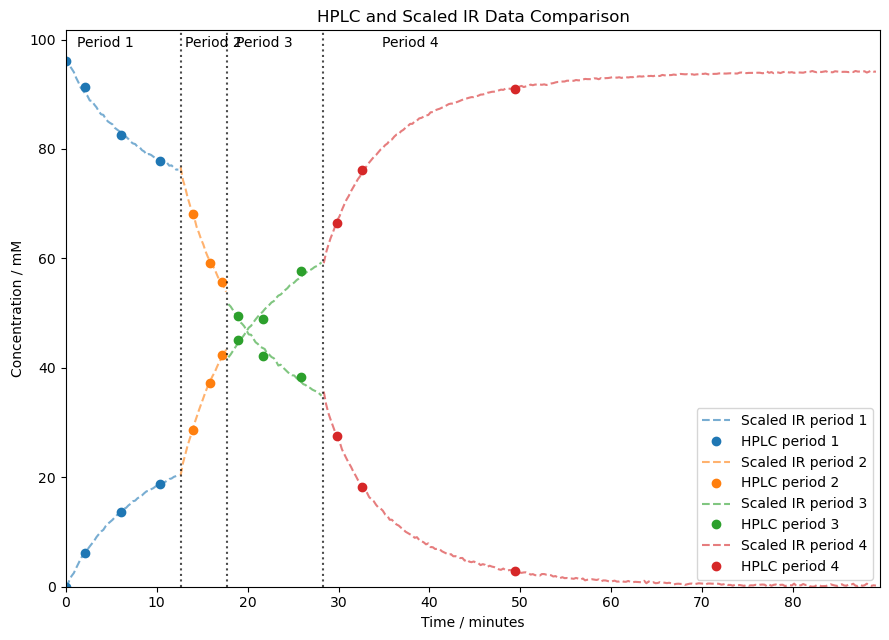

Generating HPLC IR Scaling plot for C1_E7:


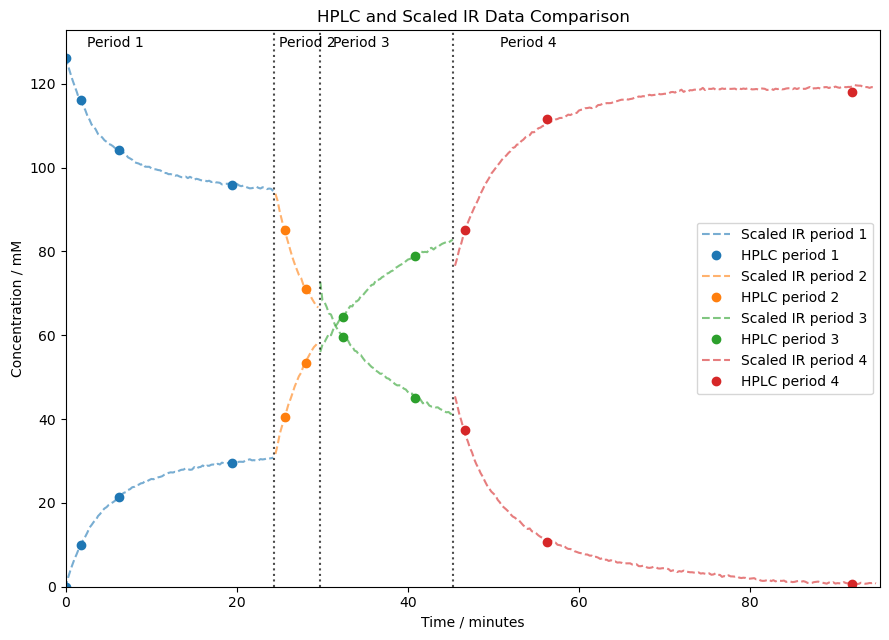

Generating HPLC IR Scaling plot for C2_E1:


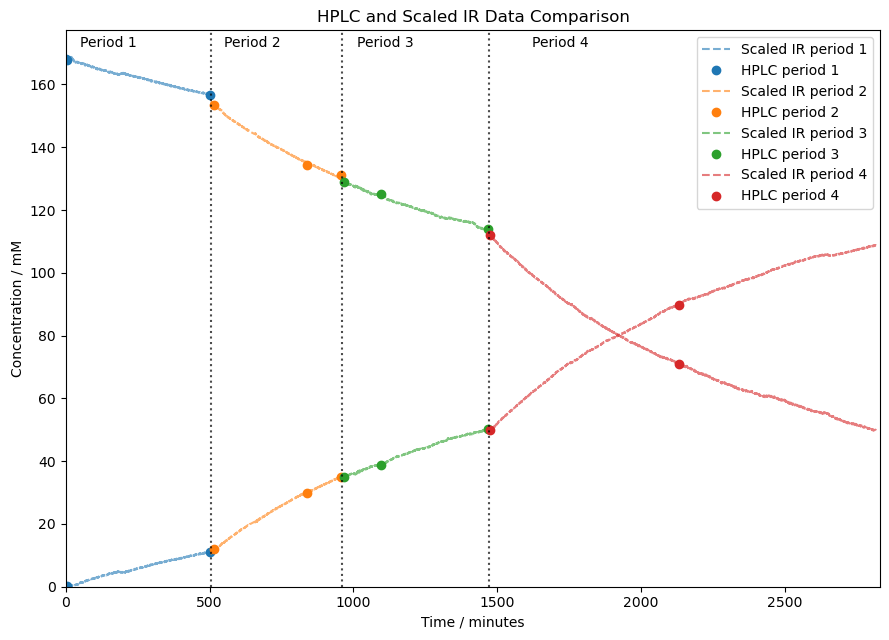

Generating HPLC IR Scaling plot for C2_E2:


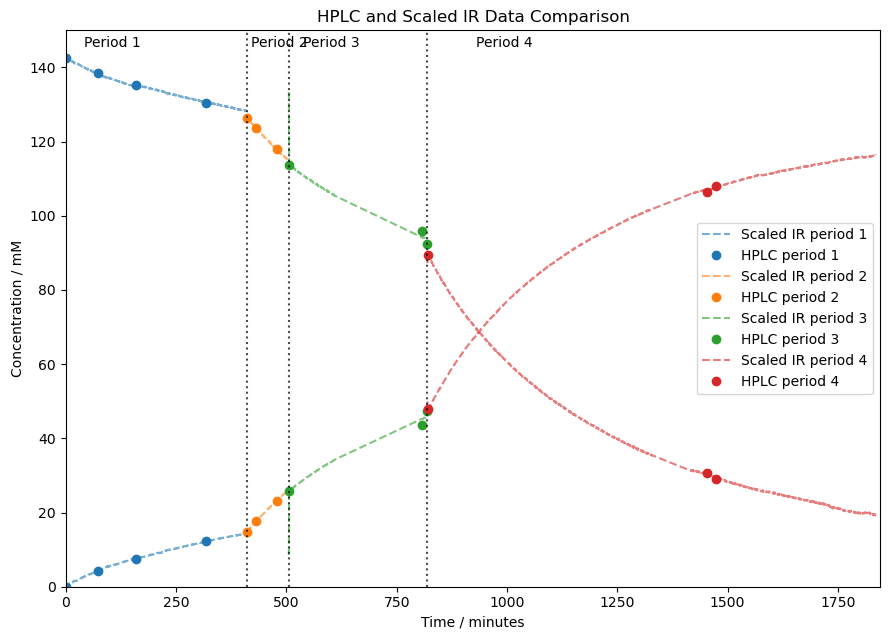

Generating HPLC IR Scaling plot for C2_E3:


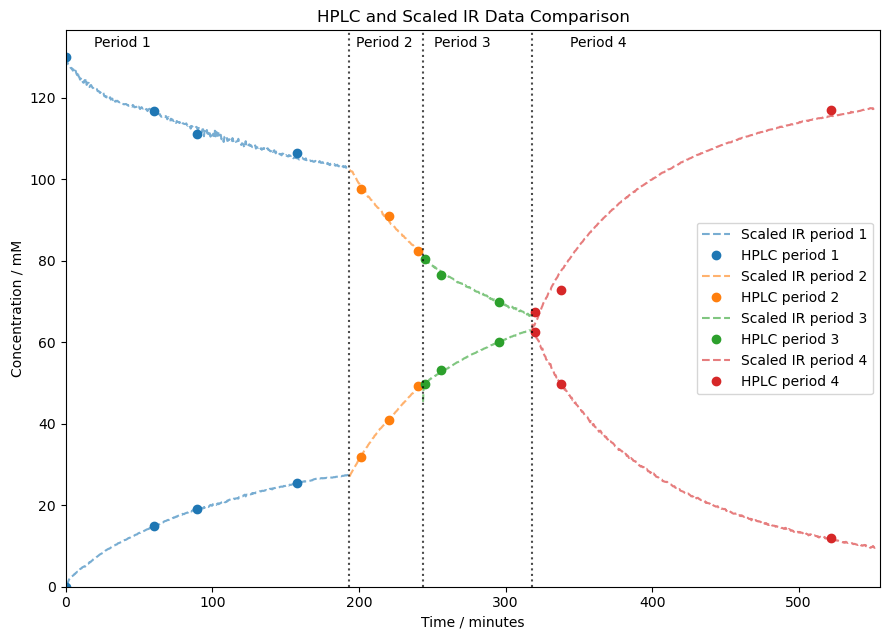

Generating HPLC IR Scaling plot for C2_E4:


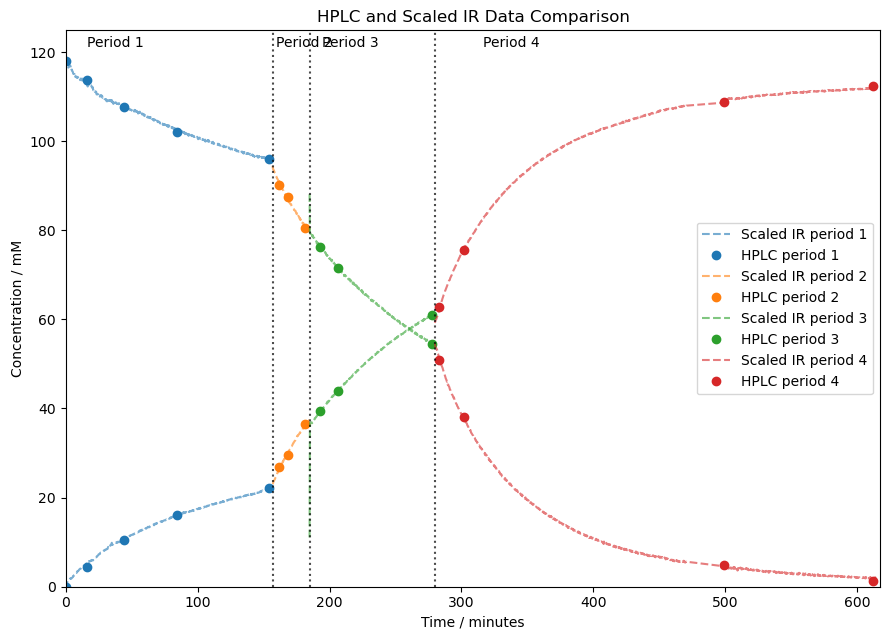

Generating HPLC IR Scaling plot for C2_E5:


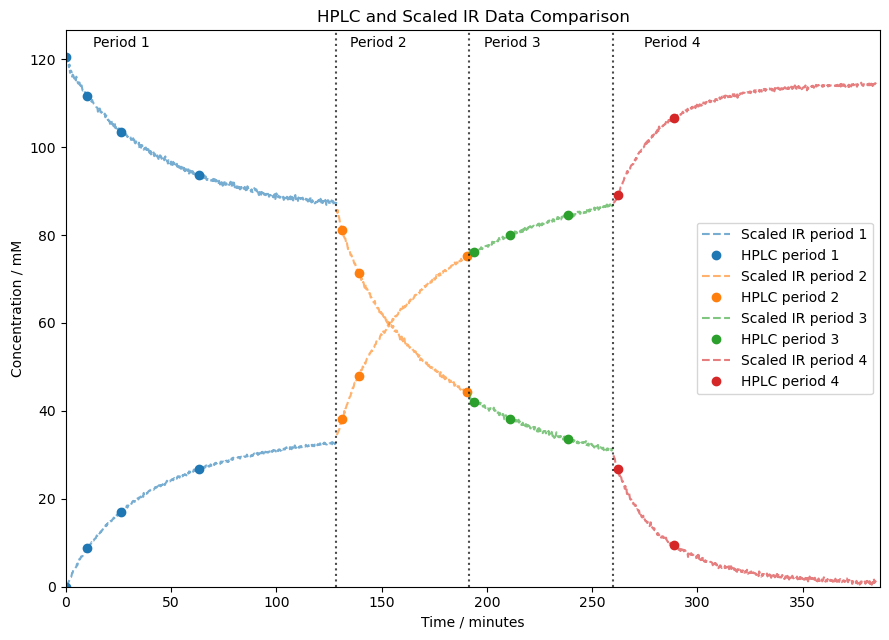

Generating HPLC IR Scaling plot for C2_E6:


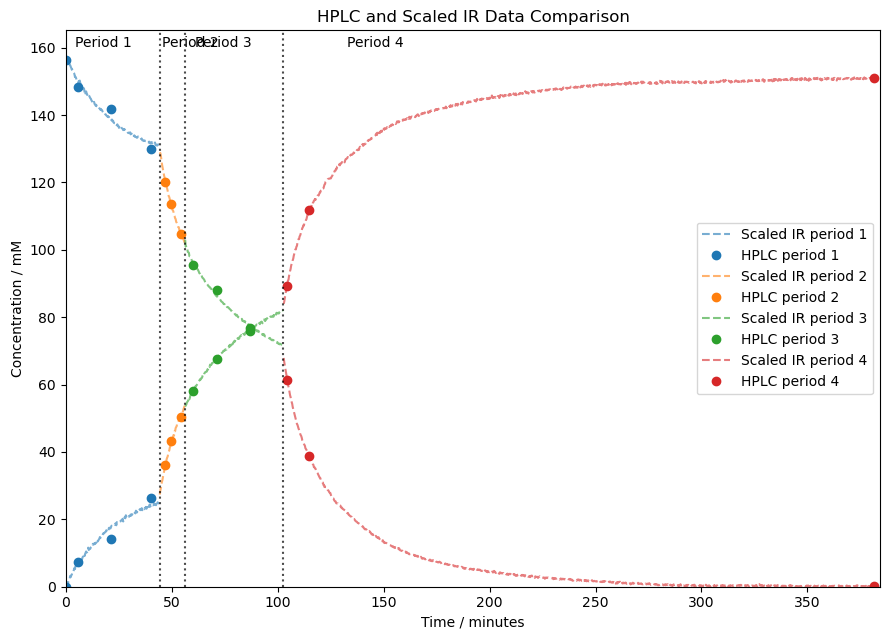

Generating HPLC IR Scaling plot for C2_E7a:


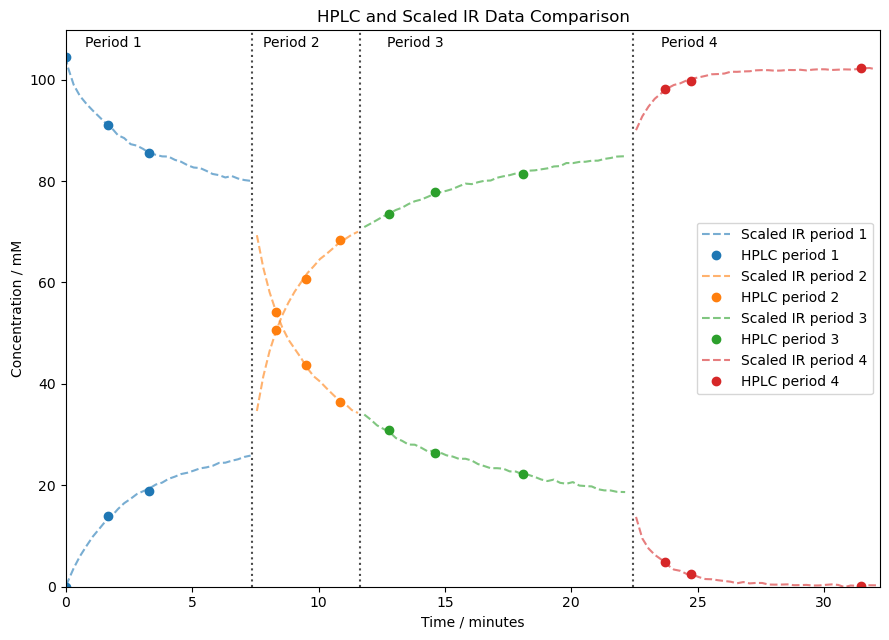

Generating HPLC IR Scaling plot for C2_E7b:


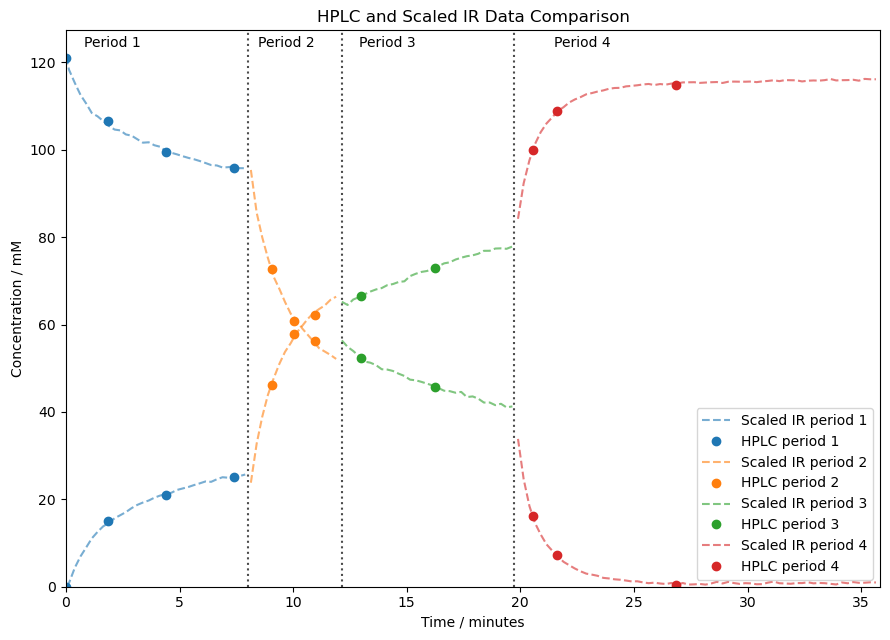

Generating HPLC IR Scaling plot for C3_E1:


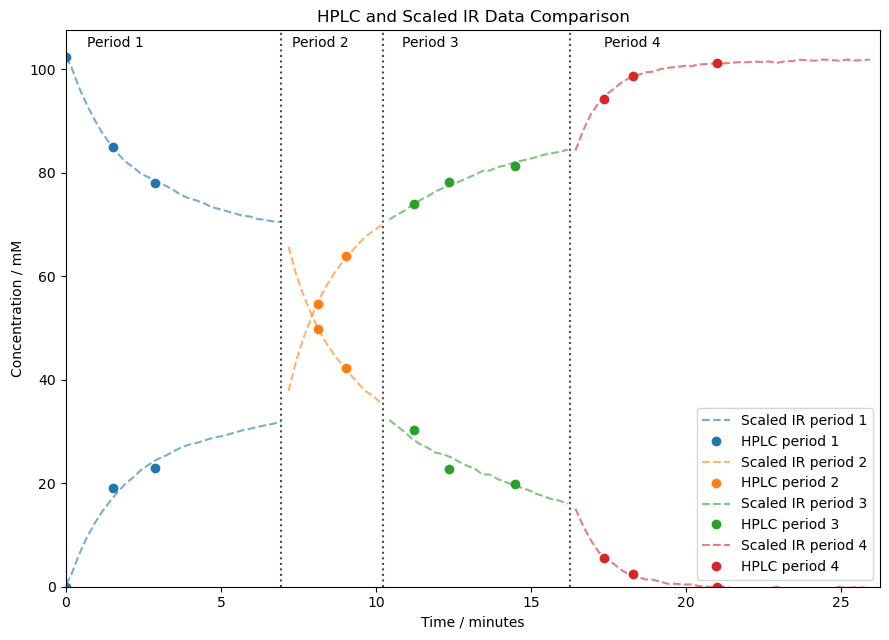

Generating HPLC IR Scaling plot for C3_E2:


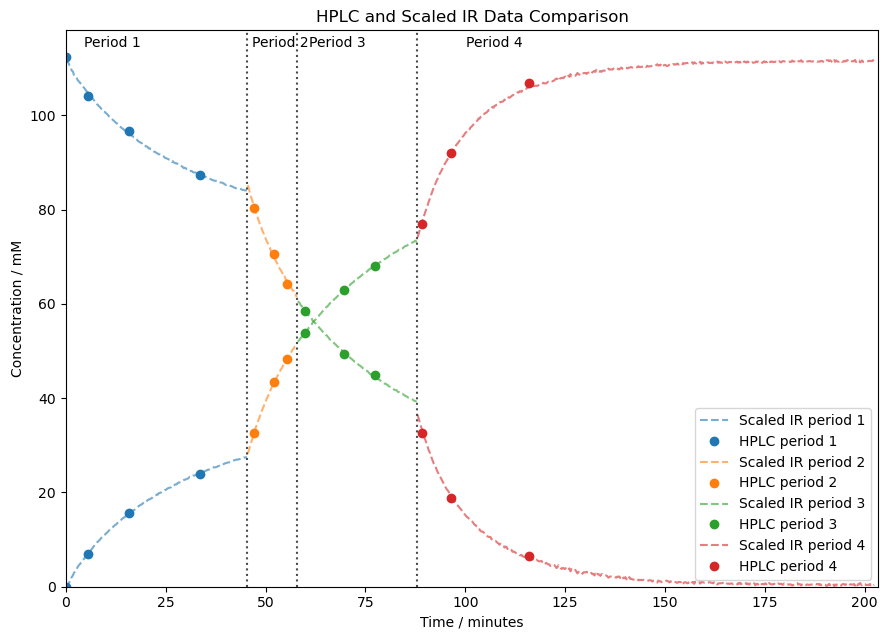

Generating HPLC IR Scaling plot for C3_E3:


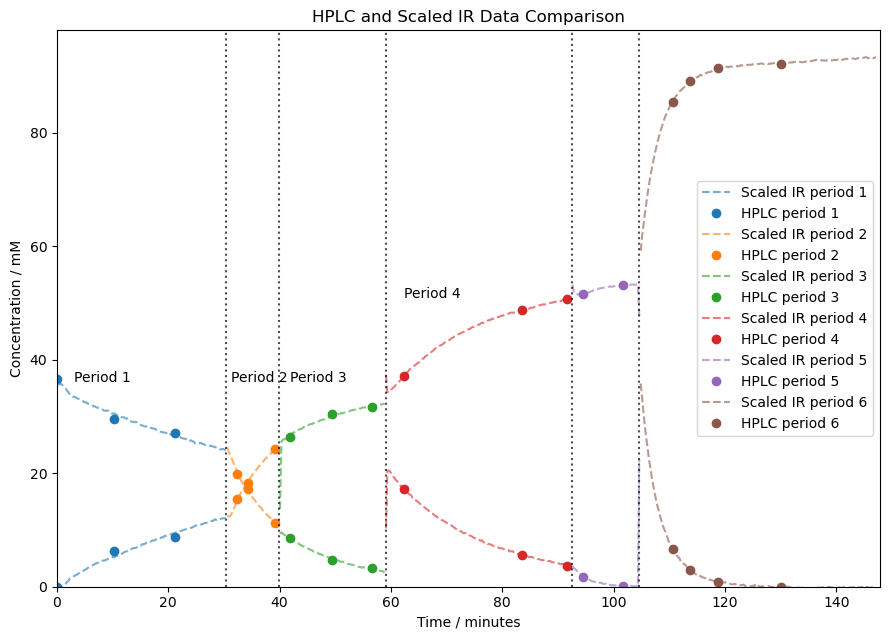

Generating HPLC IR Scaling plot for C3_E4:


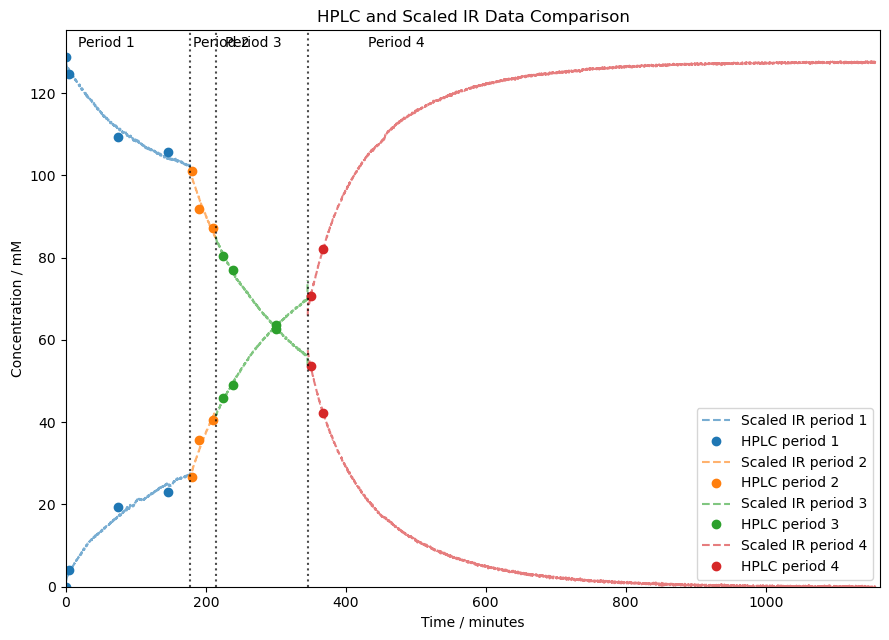

Generating HPLC IR Scaling plot for C3_E5:


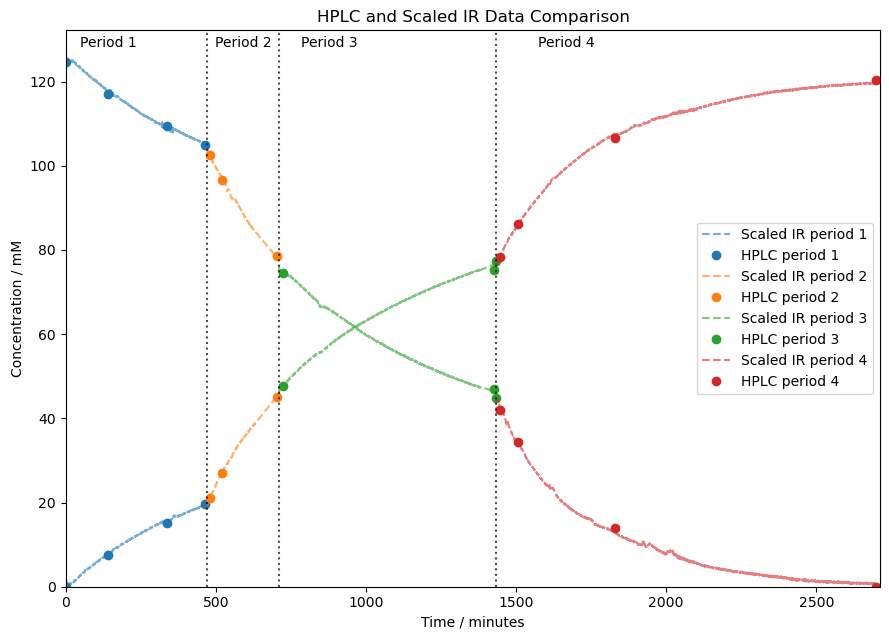

Generating HPLC IR Scaling plot for C4_E10:


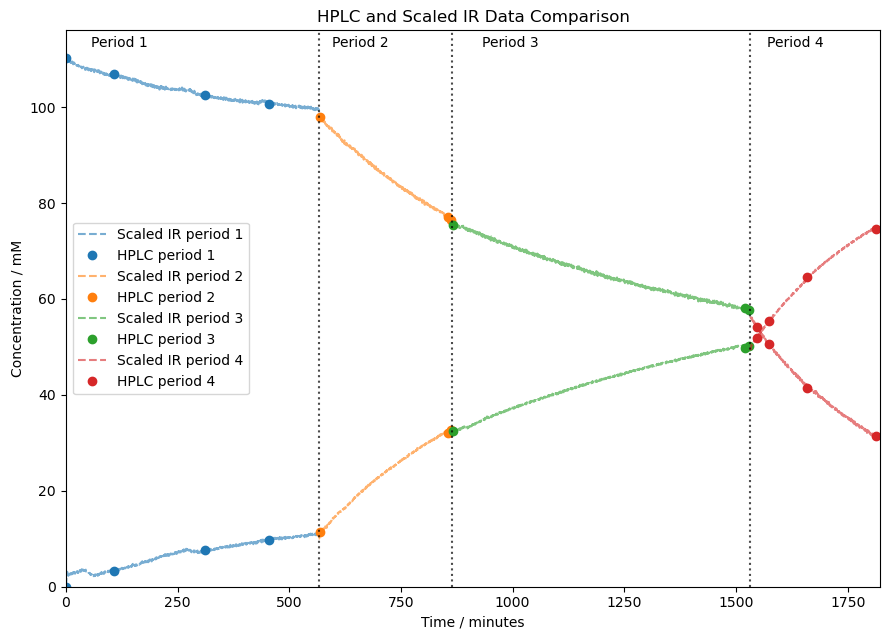

Generating HPLC IR Scaling plot for C4_E11:


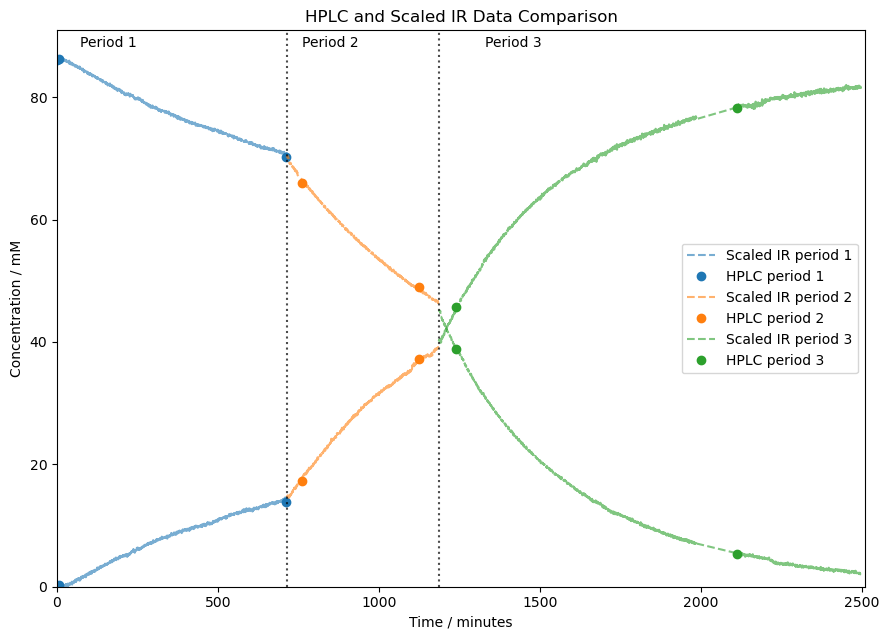

Generating HPLC IR Scaling plot for C4_E1a:


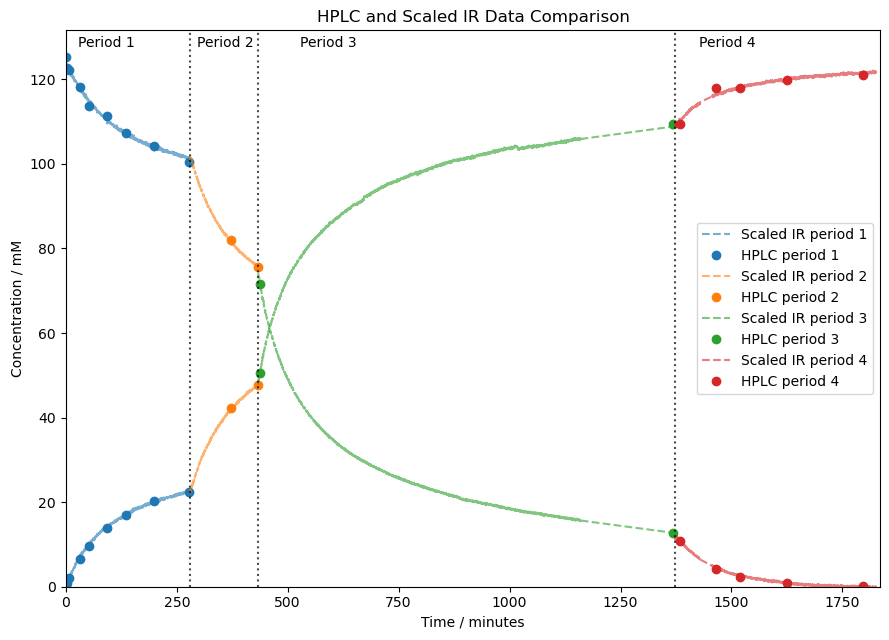

Generating HPLC IR Scaling plot for C4_E1b:


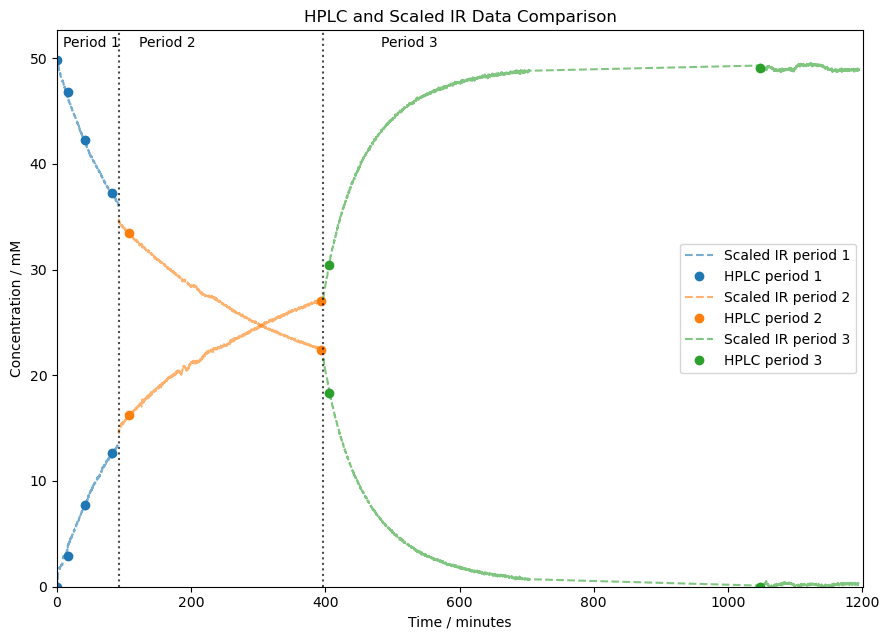

Generating HPLC IR Scaling plot for C4_E2:


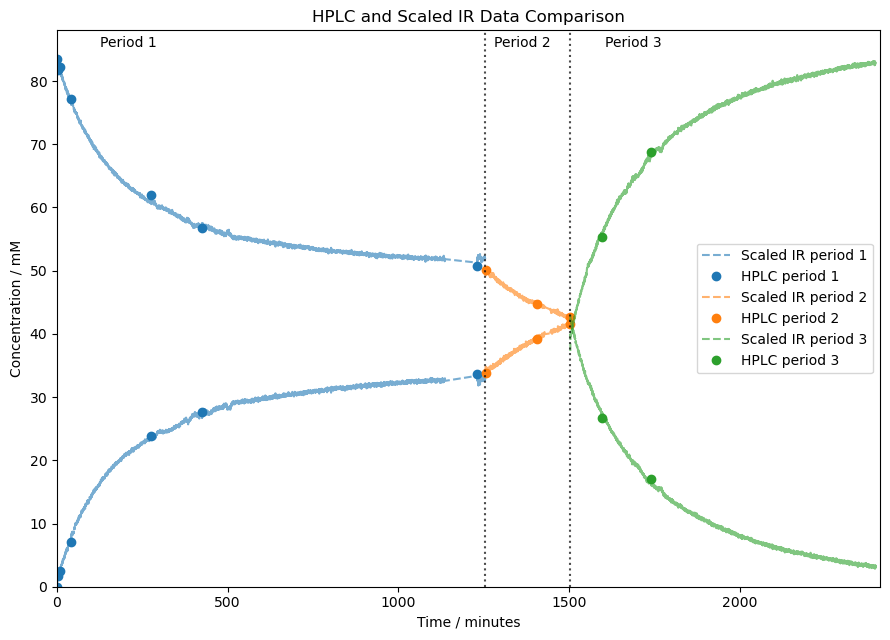

Generating HPLC IR Scaling plot for C4_E3:


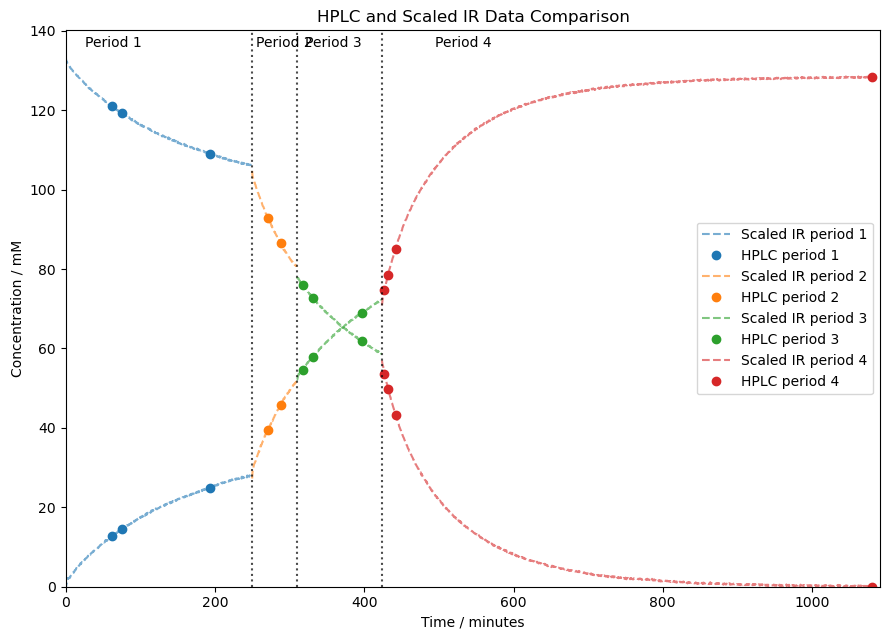

Generating HPLC IR Scaling plot for C4_E4:


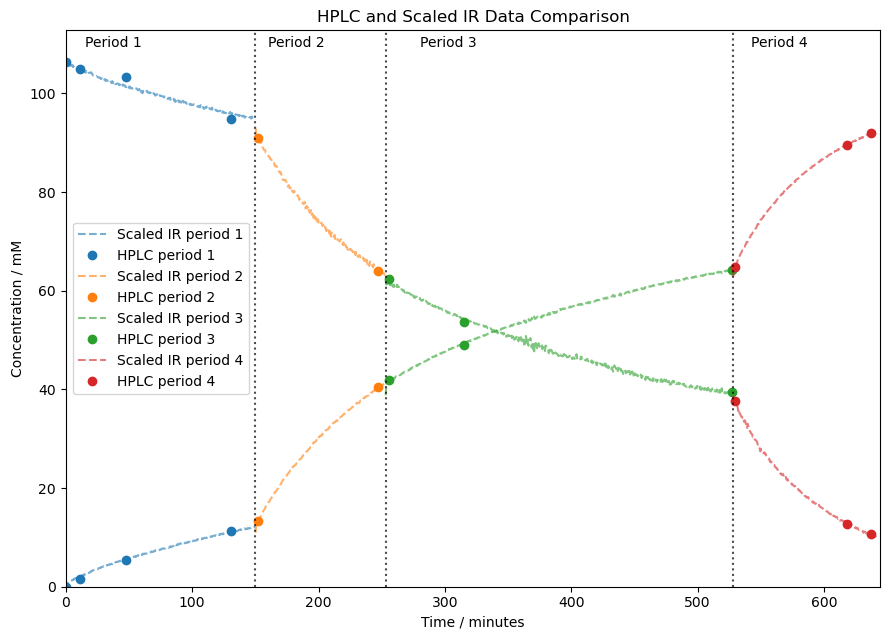

Generating HPLC IR Scaling plot for C4_E5:


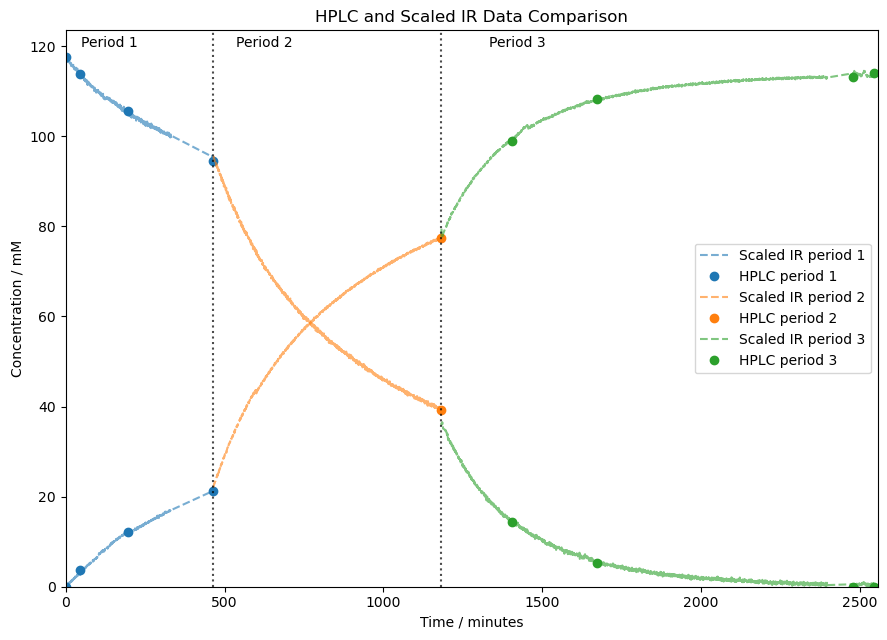

Generating HPLC IR Scaling plot for C4_E6:


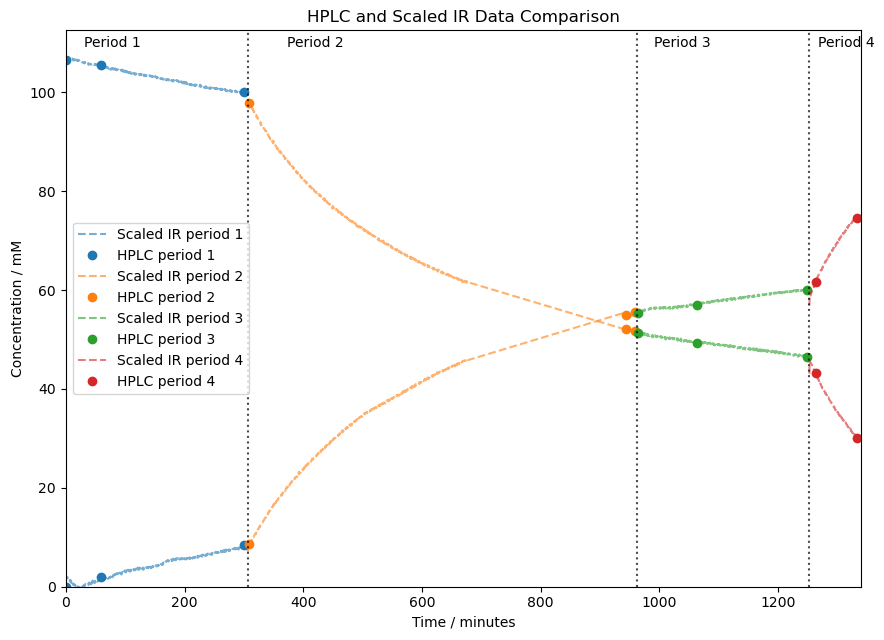

Generating HPLC IR Scaling plot for C4_E7:


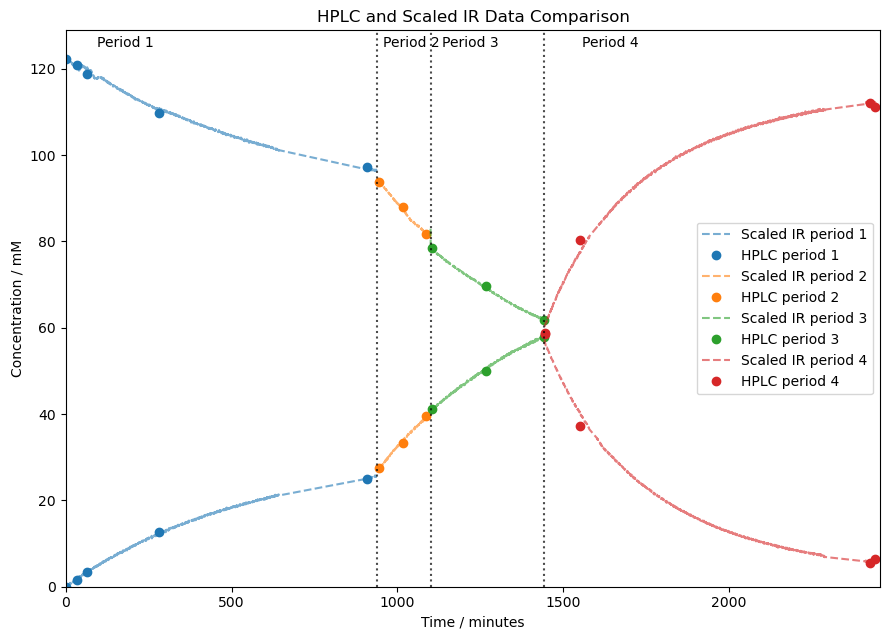

Generating HPLC IR Scaling plot for C4_E8:


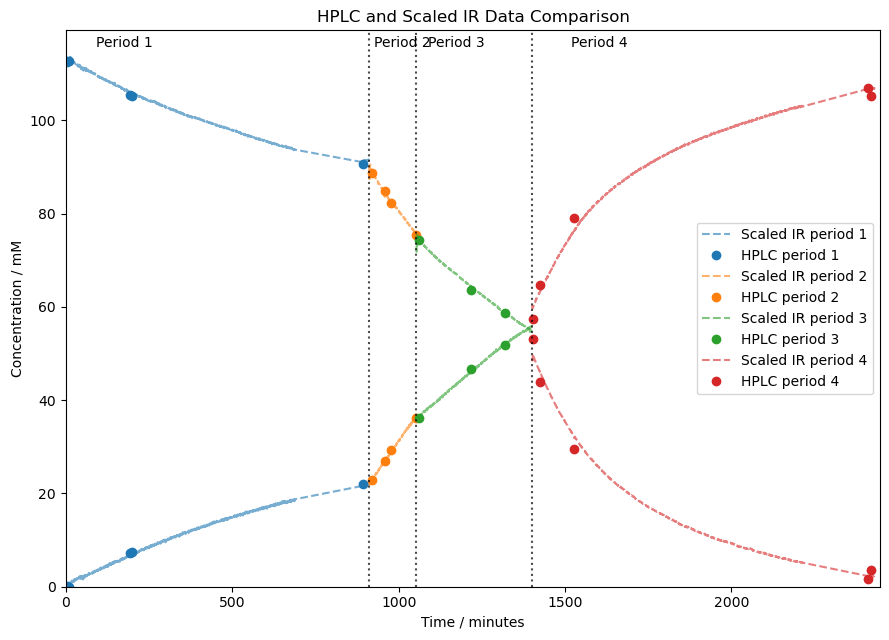

Generating HPLC IR Scaling plot for C4_E9:


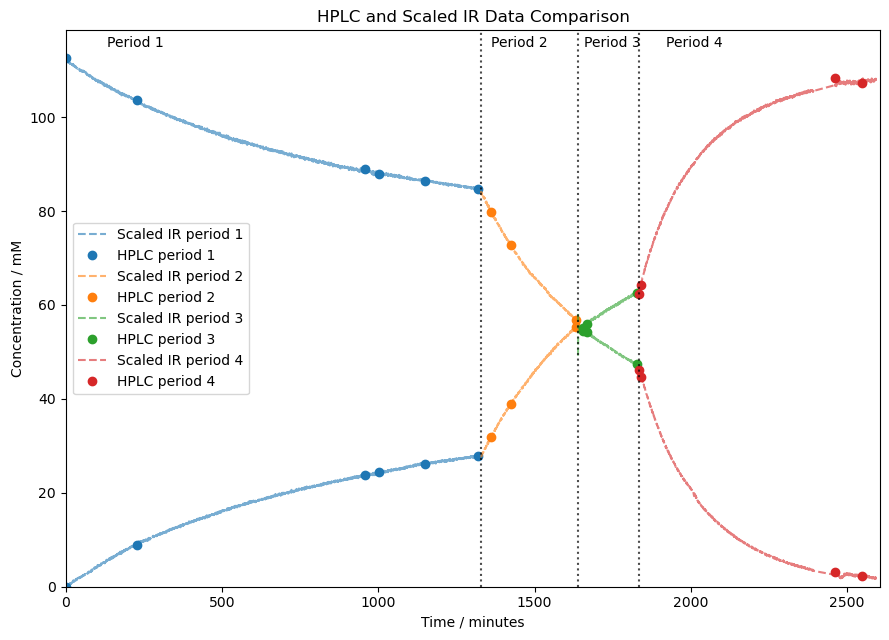

In [10]:
for exp in Experiments:
    print("\033[1mGenerating HPLC IR Scaling plot for \033[0m"+ exp+':')
    ir_file = path_IR_trends + f'\\{exp}_trends_data.csv'
    hplc_file = path_HPLC +f'\\{exp} data HPLC.csv'
    additions_file = path_Additions + f'\\{exp} additions.csv'
    output= f'{exp} VTNA dataset.xlsx'
    scale_and_save_to_excel_full_dataset(ir_file, hplc_file, additions_file,
                                         output,labels=['Period 1','Period 2','Period 3','Period 4'],figsize=[9,6.5],
                                         borders=True,legend_fontscale=1,legend_outside=False,save_vtna_dataset=False,save_svg=False)